In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.metrics import mean_squared_error

# Metro Interstate Traffic Volume

| Column | Description |
| :-- | --: | 
| `date_time` (index) | Hour of the data collected in local CST time|
| `holiday` | US National holidays plus regional holiday (Minnesota State Fair) | 
| `temp` | Average temp (in kelvin) |
| `rain_1h` | Amount in mm of rain that occurred in the hour |
| `snow_1h` | Amount in mm of snow that occurred in the hour |
| `clouds_all` | Percentage of cloud cover |
| `weather_main` | Short textual description of the current weather |
| `weather_description` | Longer textual description of the current weather |
| `traffic_volume` | Hourly I-94 ATR 301 reported westbound traffic volume |

In [2]:
# load data
path = '/Users/liamhettinger/Documents/Portfolio_work/Data/metro.csv'
data = pd.read_csv(path,index_col='date_time',parse_dates=True)
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2016-01-01 00:00:00,New Years Day,265.94,0.0,0.0,90,Haze,haze,1513
2016-01-01 00:00:00,New Years Day,265.94,0.0,0.0,90,Snow,light snow,1513
2016-01-01 01:00:00,NaN,266.00,0.0,0.0,90,Snow,light snow,1550
2016-01-01 03:00:00,NaN,266.01,0.0,0.0,90,Snow,light snow,719
2016-01-01 04:00:00,NaN,264.80,0.0,0.0,90,Clouds,overcast clouds,533


In [3]:
data.holiday = data.holiday.fillna('No')

In [4]:
data = data.iloc[1: , :]

In [5]:
#Define X and y
X = data.drop(['traffic_volume','weather_description'], axis= 1)
y = data.traffic_volume

In [6]:
#Defining categorical and continuous variables
cat = ['holiday','weather_main']
num = ['temp', 'rain_1h', 'snow_1h']

In [7]:
# categorical features
cat_processor = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# continuous feature
num_processor = Pipeline(steps=[
    ('scaler', StandardScaler())
])

processor = ColumnTransformer(transformers=[
    ('cat_processor',cat_processor,cat),
    ('num_processor',num_processor,num)
])

pipe = Pipeline(steps=[
    ('preprocessor',processor),
    ('lin_reg', Lasso())
])

In [8]:
#define parameters
parameters = {
    'lin_reg__alpha' : [.5, 1, 1.5],
    'lin_reg__tol' : [0.0001, 0.001],
    'lin_reg__max_iter' : [10000, 50000, 100000]
}

In [9]:
#defining cross validation
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

In [10]:
#define grid search
grid = GridSearchCV(pipe, parameters, cv = cv, scoring = 'neg_root_mean_squared_error', verbose=True)

In [11]:
# fitting grid
grid.fit(X,y)

Fitting 15 folds for each of 18 candidates, totalling 270 fits


GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=1),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat_processor',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['holiday',
                                                                          'weather_main']),
                                                                        ('num_processor',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['temp',
                                                                          'rain_1h',
                                                                          'snow_1h'])])),
                                       ('lin_reg', Lasso())]),
             param_grid={'lin_reg__alpha': [0.5, 1, 1.5],
                         'lin_reg__max_iter': [10000, 50000, 100000],
                         'lin_reg__tol': [0.0001, 0.001]},
             scoring='neg_root_mean_squared_error', verbose=True)

In [12]:
# predicting y values
y_pred = grid.predict(X)

In [13]:
#lasso model MSE
Lasso_MSE = mean_squared_error(y,y_pred)
Lasso_MSE

3721223.2254884257

In [14]:
#feature importance dataframe
coeff_df = pd.DataFrame(data=grid.best_estimator_['lin_reg'].coef_,
                        index=grid.best_estimator_.named_steps.preprocessor.get_feature_names_out(),
                        columns=['coefficient'])

<Axes: title={'center': 'Lasso Coefficients'}>

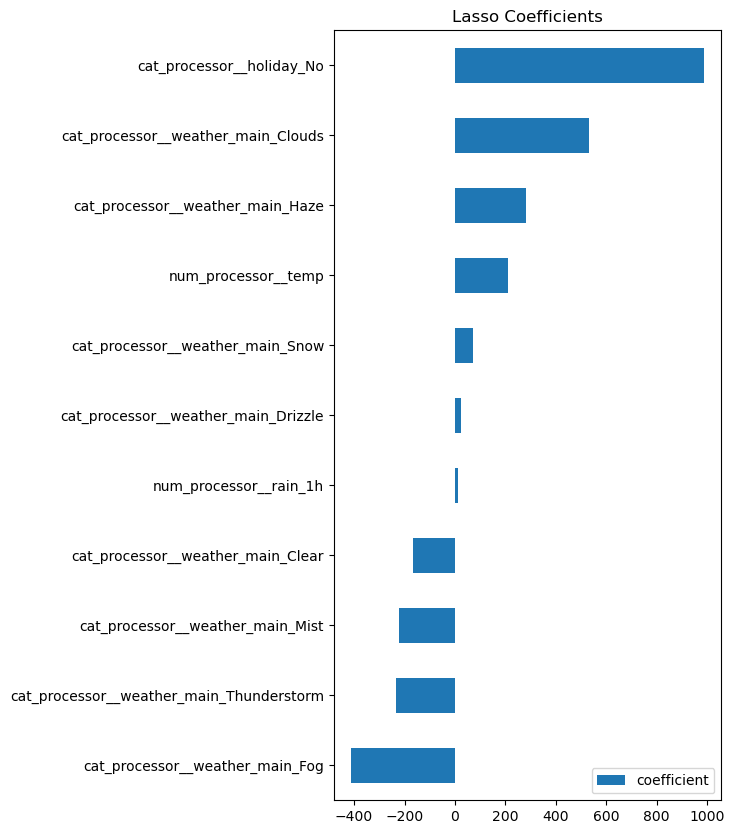

In [15]:
#feature importance graph
coeff_df[coeff_df.coefficient != 0].sort_values(by='coefficient').plot.barh(figsize=(5,10), title = 'Lasso Coefficients')

### Lasso Model

In [16]:
pipe.steps.append(('lin_reg', LinearRegression()))
pipe.steps.pop(1)

('lin_reg', Lasso())

In [17]:
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_processor',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['holiday', 'weather_main']),
                                                 ('num_processor',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'rain_1h',
                                                   'snow_1h'])])),
                ('lin_reg', LinearRegression())])

In [18]:
#define parameters
parameters = {
    'lin_reg__fit_intercept': [True, False]
}

In [19]:
#define grid search
grid = GridSearchCV(pipe, parameters, cv = cv, scoring = 'neg_root_mean_squared_error', verbose=True)

In [20]:
grid.fit(X,y)

Fitting 15 folds for each of 2 candidates, totalling 30 fits


GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=1),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat_processor',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['holiday',
                                                                          'weather_main']),
                                                                        ('num_processor',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['temp',
                                                                          'rain_1h',
                                                                          'snow_1h'])])),
                                       ('lin_reg', LinearRegression())]),
             param_grid={'lin_reg__fit_intercept': [True, False]},
             scoring='neg_root_mean_squared_error', verbose=True)

In [21]:
# predicting y values
y_pred = grid.predict(X)

In [22]:
#Linear Regression MSE
mean_squared_error(y,y_pred)

3718473.938101695

In [23]:
Lasso_MSE

3721223.2254884257

In [24]:
#feature importance dataframe
coeff_df_lin = pd.DataFrame(data=grid.best_estimator_['lin_reg'].coef_,
                        index=grid.best_estimator_.named_steps.preprocessor.get_feature_names_out(),
                        columns=['coefficient'])

<Axes: title={'center': 'Linear Regression Coefficients'}>

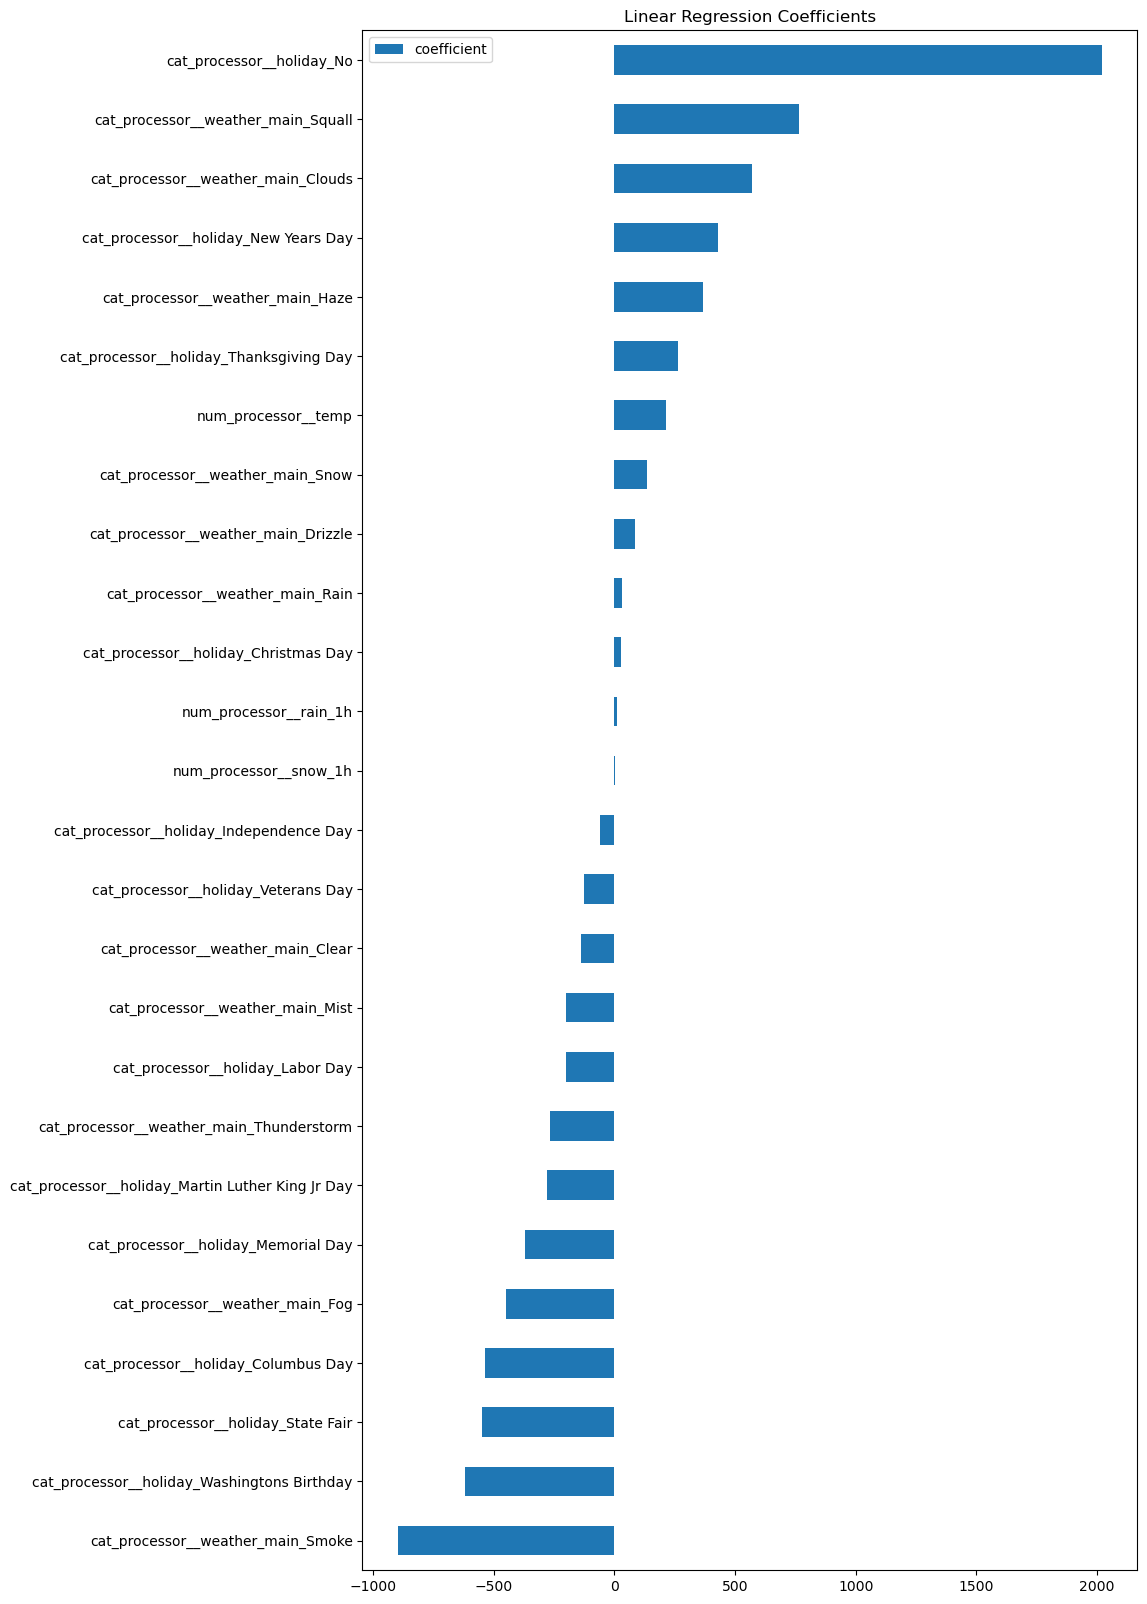

In [25]:
#feature importance graph
coeff_df_lin[coeff_df_lin.coefficient != 0].sort_values(by='coefficient').plot.barh(figsize=(10,20), title = 'Linear Regression Coefficients')


